In [1]:
# Cell 0 — Imports & config
import numpy as np
from pathlib import Path

data_dir    = Path("./data")
phase_idx   = 0          # first phase
nBH         = 2          # two breath-holds
save_outputs = False     # switch to True to np.save outputs

print(f"Data directory: {data_dir}")
print(f"Phase index: {phase_idx}, Number of BHs: {nBH}, Save outputs: {save_outputs}")

Data directory: data
Phase index: 0, Number of BHs: 2, Save outputs: False


In [2]:
# Cell 1 — Load dimensions & metadata
# Dim info
diminfo = np.fromfile(data_dir / "u_DimInfo.raw", dtype=np.uint32)
nCol, nLin, nPar, nPhs, nCha = diminfo[:5]
print(f"nCol={nCol}, nLin={nLin}, nPar={nPar}, nPhs={nPhs}, nCha={nCha}")

# Per-BH readout arrays and readout info
readout_array = []
readout_info  = []

for b in range(nBH):
    ra = np.fromfile(data_dir / f"u_readoutarray_{b}.raw", dtype=np.uint32)
    readout_array.append(ra)
    print(f"BH{b} readout array length {len(ra)}, first values {ra[:min(5,len(ra))]}")

    ri = np.fromfile(data_dir / f"ri_ReadoutInfoData_{b}.raw", dtype=np.int64).reshape(-1,5)
    readout_info.append(ri)
    print(f"BH{b} readout info shape {ri.shape}")

    # Phase-specific
    n_reads = ra[phase_idx]
    start   = ra[:phase_idx].sum()
    end     = start + n_reads
    sample = ri[start:end, :2]
    print(f" BH{b} phase {phase_idx}: reads={n_reads}, start={start}, end={end}")
    print(f"  sample (ky,kz):\n{sample[:min(5,len(sample))]}")
    # optional warning
    bad = np.logical_or(sample[:,0] < 0, sample[:,0] >= nLin) | np.logical_or(sample[:,1] < 0, sample[:,1] >= nPar)
    if bad.any():
        print(f"  Warning: {bad.sum()} out-of-range (ky,kz) entries in BH{b}")

nCol=160, nLin=128, nPar=72, nPhs=20, nCha=24
BH0 readout array length 20, first values [331 325 324 323 321]
BH0 readout info shape (6466, 5)
 BH0 phase 0: reads=331, start=0, end=331
  sample (ky,kz):
[[ 0  0]
 [ 0  2]
 [ 0  6]
 [ 0 12]
 [ 0 20]]
BH1 readout array length 20, first values [350 334 342 333 341]
BH1 readout info shape (6772, 5)
 BH1 phase 0: reads=350, start=0, end=350
  sample (ky,kz):
[[ 0  0]
 [ 0  4]
 [ 0  8]
 [ 0 16]
 [ 0 24]]


In [3]:
# Cell 2 — Load raw k-space streams as complex
def load_complex(path):
    rawf = np.fromfile(path, dtype=np.float32)
    if len(rawf) % 2:
        print(f"  Warning: odd float count ({len(rawf)}) in {path.name}")
    cpx = rawf.view(np.complex64)
    return cpx

kspace_stream = []
for b in range(nBH):
    path = data_dir / f"cf_kspace_{b}.raw"
    ks   = load_complex(path)
    kspace_stream.append(ks)
    expected = readout_array[b].sum() * nCol * nCha
    print(f"BH{b} stream: {path.stat().st_size} bytes → {len(ks)} complex samples (expected {expected})")
    if len(ks) < expected:
        print(f"  Warning: fewer samples than expected; data may be truncated")
    elif len(ks) > expected:
        print(f"  Warning: extra samples will be ignored in phase build")

BH0 stream: 198635520 bytes → 24829440 complex samples (expected 24829440)
BH1 stream: 208035840 bytes → 26004480 complex samples (expected 26004480)


In [4]:
# Cell 3 — Build per-BH k-space for phase 0
kspace_b = [np.zeros((nCol, nLin, nPar, nCha), dtype=np.complex64)
            for _ in range(nBH)]
mask_b   = []
dup_b    = []

for b in range(nBH):
    ra    = readout_array[b]
    ri    = readout_info[b]
    ks    = kspace_stream[b]
    n_reads     = ra[phase_idx]
    base_reads  = ra[:phase_idx].sum()
    dup_count   = 0

    for i in range(n_reads):
        ky, kz = ri[base_reads + i, :2]
        for c in range(nCha):
            offset = base_reads*(nCha*nCol) + c*(n_reads*nCol) + i*nCol
            seg    = ks[offset : offset + nCol]
            dest   = kspace_b[b][:, ky, kz, c]
            if np.any(dest):
                dup_count += 1
            else:
                kspace_b[b][:, ky, kz, c] = seg

    m = np.any(np.abs(kspace_b[b]) > 0, axis=(0,3))
    mask_b.append(m)
    dup_b.append(dup_count)
    print(f"BH{b}: nonzero ky/kz count = {m.sum()}, duplicates = {dup_count}")

BH0: nonzero ky/kz count = 331, duplicates = 0
BH1: nonzero ky/kz count = 350, duplicates = 0


In [5]:
# Cell 4 — Combine BHs (union) and final outputs
kspace_phase = np.zeros_like(kspace_b[0])
# first-wins: fill BH0 then BH1 only into zeros
kspace_phase[:] = kspace_b[0]
for b in [1]:
    nz = np.abs(kspace_phase) == 0
    kspace_phase[nz] = kspace_b[b][nz]

mask_phase = np.any(np.abs(kspace_phase) > 0, axis=(0,3))
print(f"Mask counts → BH0: {mask_b[0].sum()}, BH1: {mask_b[1].sum()}, Combined: {mask_phase.sum()}")

print(f"Combined k-space: shape {kspace_phase.shape}, dtype {kspace_phase.dtype}")
print(f" Total nonzero samples: {np.count_nonzero(np.abs(kspace_phase)>0)}")

# reordered view for FFT later
kspace_phase_c = np.moveaxis(kspace_phase, -1, 0)
print(f"Reordered view shape: {kspace_phase_c.shape}")

# Optionally save
if save_outputs:
    np.save(data_dir / "kspace_phase.npy", kspace_phase)
    np.save(data_dir / "kspace_phase_c.npy", kspace_phase_c)
    np.save(data_dir / "mask_phase.npy", mask_phase.astype(np.uint8))
    print("Saved kspace_phase.npy, kspace_phase_c.npy, mask_phase.npy")

Mask counts → BH0: 331, BH1: 350, Combined: 680
Combined k-space: shape (160, 128, 72, 24), dtype complex64
 Total nonzero samples: 2611200
Reordered view shape: (24, 160, 128, 72)


kspace_phase: (160, 128, 72, 24) complex64
|img_sos| stats → min 4.9975e-05, mean 6.9640e-04, 99th pct 2.6670e-03, max 4.1137e-03


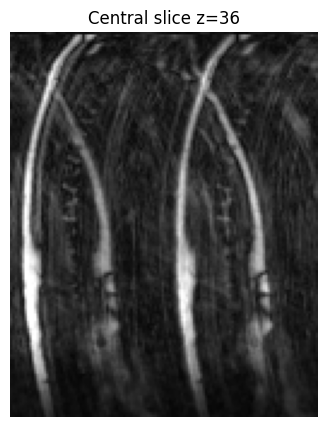

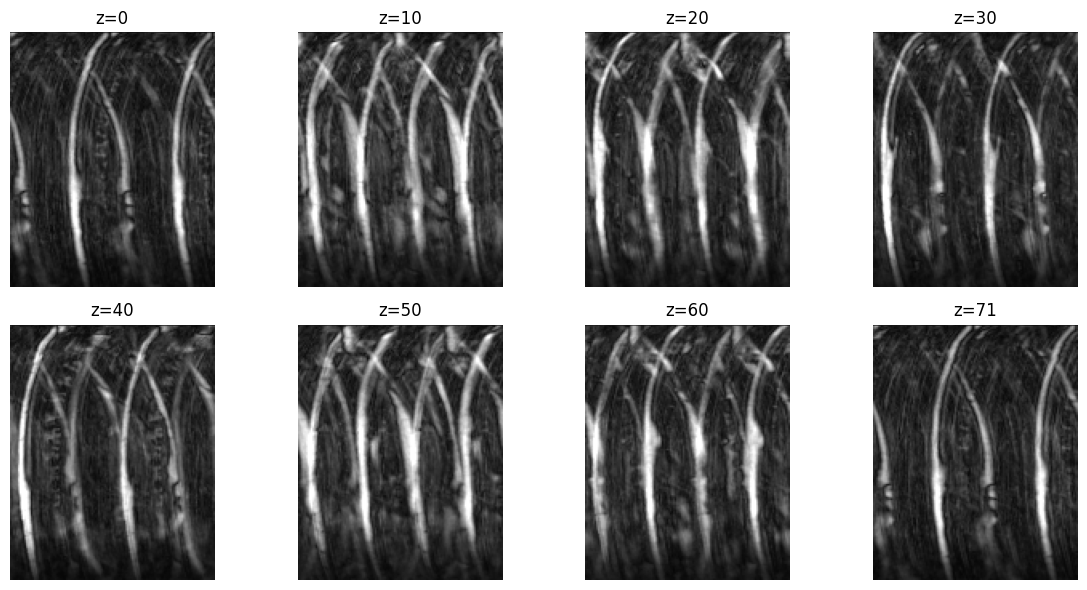

Note: Aliasing expected due to undersampling; this is a sanity view.


In [6]:
# Zero-filled SOS reconstruction (no SENSE/DC)
import numpy as np
import matplotlib.pyplot as plt

# 1. Inspect k-space
print("kspace_phase:", kspace_phase.shape, kspace_phase.dtype)

# 2. Reorder to (coils, kx, ky, kz)
kspace_c = np.moveaxis(kspace_phase, -1, 0)

# 3. Centered IFFTN helper
def ifftn_centered(x, axes=(1,2,3), norm='ortho'):
    x = np.fft.ifftshift(x, axes=axes)
    x = np.fft.ifftn(x, axes=axes, norm=norm)
    return np.fft.fftshift(x, axes=axes)

# 4. Zero-filled inverse FFT per coil
img_coils = ifftn_centered(kspace_c, axes=(1,2,3), norm='ortho')

# 5. Sum-of-squares coil combine
img_sos = np.sqrt(np.sum(np.abs(img_coils)**2, axis=0))

# 6. Print basic stats
mag   = np.abs(img_sos)
mn    = mag.min()
mean  = mag.mean()
p99   = np.percentile(mag, 99)
mx    = mag.max()
print(f"|img_sos| stats → min {mn:.4e}, mean {mean:.4e}, 99th pct {p99:.4e}, max {mx:.4e}")

# 7. Display central z-slice
z0 = img_sos.shape[2] // 2
plt.figure(figsize=(5,5))
plt.imshow(mag[:, :, z0], cmap='gray', vmin=0, vmax=p99)
plt.title(f"Central slice z={z0}")
plt.axis('off')
plt.show()

# 8. Montage of 8 evenly spaced z-slices
zs = np.linspace(0, img_sos.shape[2]-1, 8, dtype=int)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for ax, z in zip(axes.flat, zs):
    ax.imshow(mag[:, :, z], cmap='gray', vmin=0, vmax=p99)
    ax.set_title(f"z={z}")
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Note: Aliasing expected due to undersampling; this is a sanity view.")

In [7]:
# Cell CG0 — Imports, reorder, mask & coil map loading
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# inspect and reorder k-space
print("kspace_phase:", kspace_phase.shape, kspace_phase.dtype)
kspace_c = np.moveaxis(kspace_phase, -1, 0)   # (coils, kx, ky, kz)

# derive mask if needed
try:
    mask_phase
except NameError:
    mask_phase = np.any(np.abs(kspace_phase)>0, axis=(0,3))
mask_b = mask_phase[None, None, :, :]         # (1,1,ky,kz)

# load coil sensitivity map
csm_path = Path("./data") / "cf_coil_sensitivity_AVG_0.raw"
raw = np.fromfile(csm_path, dtype=np.float32)
if len(raw)%2:
    print(f"Warning: odd float count in {csm_path.name}")
cplx = raw.view(np.complex64)
csm = cplx.reshape(kspace_phase.shape, order='F')  # (kx,ky,kz,coils)
sens = np.moveaxis(csm, -1, 0)                     # (coils, kx, ky, kz)
sens = np.flip(np.flip(np.flip(sens, axis=1), axis=2), axis=3)

# normalize
ss = np.sqrt(np.sum(np.abs(sens)**2, axis=0)) + 1e-8
sens /= ss

print("kspace_c:", kspace_c.shape)
print("mask_phase:", mask_phase.shape)
print("sens:", sens.shape, "mean|∑|S|²–1|=", np.mean(np.abs(np.sum(np.abs(sens)**2,0)-1)))

kspace_phase: (160, 128, 72, 24) complex64
kspace_c: (24, 160, 128, 72)
mask_phase: (128, 72)
sens: (24, 160, 128, 72) mean|∑|S|²–1|= 8.768637e-08


In [8]:
# Cell CG1 — Define operators & RHS
lam = 1e-6

def A(x):
    # x: (kx,ky,kz) → k-space
    Sx = sens * x[None,...]                      
    K  = np.fft.fftn(Sx, axes=(1,2,3), norm='ortho')
    return mask_b * K

def AH(y):
    # y: (coils,kx,ky,kz) → image
    ym = mask_b * y
    imc = np.fft.ifftn(ym, axes=(1,2,3), norm='ortho')
    return np.sum(np.conj(sens) * imc, axis=0)

def N(x):
    return AH(A(x)) + lam * x

# build RHS and initial guess
rhs = AH(kspace_c)
x   = rhs.copy()
print("‖rhs‖ =", np.linalg.norm(rhs))

‖rhs‖ = 0.70940614


In [9]:
# Cell CG2 — Conjugate Gradient solve
max_iters = 25
tol       = 1e-6

r   = rhs - N(x)
p   = r.copy()
rsold = np.vdot(r, r).real
rs0   = rsold

for i in range(1, max_iters+1):
    Ap    = N(p)
    alpha = rsold / np.vdot(p, Ap).real
    x    += alpha * p
    r    -= alpha * Ap
    rsnew = np.vdot(r, r).real
    print(f"Iter {i:2d}, residual norm = {np.sqrt(rsnew):.3e}")
    if np.sqrt(rsnew) < tol * np.sqrt(rs0):
        break
    p, rsold = r + (rsnew/rsold)*p, rsnew

Iter  1, residual norm = 1.501e-01
Iter  2, residual norm = 8.736e-02
Iter  3, residual norm = 6.379e-02
Iter  4, residual norm = 3.627e-02
Iter  5, residual norm = 2.356e-02
Iter  6, residual norm = 2.022e-02
Iter  7, residual norm = 1.645e-02
Iter  8, residual norm = 1.272e-02
Iter  9, residual norm = 1.046e-02
Iter 10, residual norm = 1.005e-02
Iter 11, residual norm = 8.410e-03
Iter 12, residual norm = 7.552e-03
Iter 13, residual norm = 6.896e-03
Iter 14, residual norm = 6.172e-03
Iter 15, residual norm = 5.467e-03
Iter 16, residual norm = 5.297e-03
Iter 17, residual norm = 4.845e-03
Iter 18, residual norm = 4.454e-03
Iter 19, residual norm = 4.234e-03
Iter 20, residual norm = 3.928e-03
Iter 21, residual norm = 3.735e-03
Iter 22, residual norm = 3.571e-03
Iter 23, residual norm = 3.435e-03
Iter 24, residual norm = 3.252e-03
Iter 25, residual norm = 3.160e-03


|x| stats → min 6.184e-07, mean 1.081e-03, 99th pct 8.245e-03, max 1.444e-02


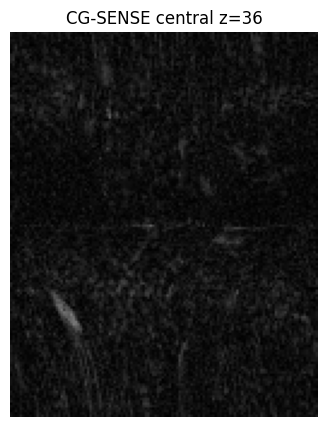

Note: No fftshift used; DC enforced via CG-SENSE.


In [10]:
# Cell CG3 — Visualization of CG-SENSE result
mag = np.abs(x)
mn, mean_, p99, mx = mag.min(), mag.mean(), np.percentile(mag,99), mag.max()
print(f"|x| stats → min {mn:.3e}, mean {mean_:.3e}, 99th pct {p99:.3e}, max {mx:.3e}")

z0 = mag.shape[2]//2
plt.figure(figsize=(5,5))
plt.imshow(mag[:,:,z0], cmap='gray', vmin=0, vmax=p99)
plt.title(f"CG-SENSE central z={z0}")
plt.axis('off')
plt.show()

print("Note: No fftshift used; DC enforced via CG-SENSE.")

In [11]:
# Package k-space, maps & reconstruction for phase 0
import numpy as np
from pathlib import Path

# 1. Print shapes & types
print("kspace_phase:", kspace_phase.shape, kspace_phase.dtype)
print("mask_phase :", mask_phase.shape, mask_phase.dtype)
print("sens       :", sens.shape, sens.dtype)
print("x          :", x.shape, x.dtype)

# 2. Reorder k-space to coils-first
kspace_c = np.moveaxis(kspace_phase, -1, 0)  # (24,160,128,72)
print("kspace_c   :", kspace_c.shape)

# 3. Acquired coordinates
acq_idx = np.argwhere(mask_phase)            # (N_acq, 2)
N_acq   = acq_idx.shape[0]
print(f"Acquired points: {N_acq} / {mask_phase.size}")

# 4. Save to compressed .npz
meta = dict(nCol=160, nLin=128, nPar=72, nCha=24,
            phase_idx=0, cg_iters=25, cg_lambda=1e-6)
out_path = Path("phase0_package.npz")
np.savez_compressed(
    out_path,
    kspace_c=kspace_c,
    mask_phase=mask_phase.astype(np.uint8),
    sens=sens,
    x=x,
    acq_idx=acq_idx.astype(np.int32),
    meta=meta
)
size = out_path.stat().st_size
print(f"Saved '{out_path.name}' ({size} bytes)")

kspace_phase: (160, 128, 72, 24) complex64
mask_phase : (128, 72) bool
sens       : (24, 160, 128, 72) complex64
x          : (160, 128, 72) complex64
kspace_c   : (24, 160, 128, 72)
Acquired points: 680 / 9216
Saved 'phase0_package.npz' (295750029 bytes)


In [12]:
# Step 0 — Load package and report acquisition
import numpy as np, time
from pathlib import Path

t0 = time.time()
pkg = np.load(Path("./")/"phase0_package.npz", allow_pickle=True)

# Mandatory mask
mask_phase = pkg["mask_phase"]
nLin, nPar = mask_phase.shape
acq_idx = np.argwhere(mask_phase)
N = acq_idx.shape[0]

# Optional arrays
for name in ("kspace_c", "sens", "x"):
    if name in pkg:
        arr = pkg[name]
        print(f"{name}.shape = {arr.shape}")

print(f"mask_phase.shape = ({nLin}, {nPar})")
print(f"|Ω| = {N}, mask_phase.sum() = {mask_phase.sum()}")
print("Sample acq_idx[:5]:", acq_idx[:5])

print(f"[PROGRESS] Step 0 done (|Ω|={N}, t={time.time()-t0:.2f}s)")

kspace_c.shape = (24, 160, 128, 72)
sens.shape = (24, 160, 128, 72)
x.shape = (160, 128, 72)
mask_phase.shape = (128, 72)
|Ω| = 680, mask_phase.sum() = 680
Sample acq_idx[:5]: [[0 0]
 [0 2]
 [0 4]
 [0 6]
 [0 8]]
[PROGRESS] Step 0 done (|Ω|=680, t=1.96s)


In [13]:
# Step 1 — Define strata over Ω
import numpy as np, time

t0 = time.time()
# assume mask_phase in memory
if 'acq_idx' not in locals():
    acq_idx = np.argwhere(mask_phase)
ky, kz = acq_idx[:,0], acq_idx[:,1]

# quantile edges
ky_edges = np.unique(np.quantile(ky, [0,.25,.5,.75,1.0]).astype(int))
kz_edges = np.unique(np.quantile(kz, [0,1/3,2/3,1.0]).astype(int))

# assign bins
ky_bin = np.digitize(ky, ky_edges[1:-1], right=True)
kz_bin = np.digitize(kz, kz_edges[1:-1], right=True)

# build strata dict: (iy,iz) -> indices into acq_idx
strata = {}
for idx,(iy,iz) in enumerate(zip(ky_bin,kz_bin)):
    strata.setdefault((iy,iz), []).append(idx)
# convert to arrays
for k in strata:
    strata[k] = np.array(strata[k], dtype=int)

# counts per stratum
Ky, Kz = len(ky_edges)-1, len(kz_edges)-1
counts = np.zeros((Ky,Kz), int)
for (iy,iz), idxs in strata.items():
    if 0 <= iy < Ky and 0 <= iz < Kz:
        counts[iy,iz] = len(idxs)

# prints
print("ky_edges:", ky_edges)
print("kz_edges:", kz_edges)
print("stratum counts (ky×kz):")
print(counts)
print("total in strata:", counts.sum(), "len(acq_idx):", len(acq_idx))
print(f"[PROGRESS] Step 1 done (strata={Ky}×{Kz}, t={time.time()-t0:.2f}s)")

ky_edges: [  0  17  60 108 126]
kz_edges: [ 0 15 54 71]
stratum counts (ky×kz):
[[66 48 58]
 [57 60 51]
 [54 65 62]
 [59 44 56]]
total in strata: 680 len(acq_idx): 680
[PROGRESS] Step 1 done (strata=4×3, t=0.00s)


In [14]:
# Step 2 — Create Γ (20% stratified) and R = Ω\Γ
import numpy as np, time

t0 = time.time()
seed = 1234
gamma_rows = []

# stratified selection per stratum
for (iby, ibz), idxs in strata.items():
    m = len(idxs)
    g = int(np.ceil(m * 0.20))
    rng = np.random.default_rng(seed + iby*10 + ibz)
    if g > 0:
        sel = rng.choice(idxs, size=g, replace=False)
        gamma_rows.extend(sel.tolist())

gamma_rows = np.array(gamma_rows, dtype=int)

# build Γ
Gamma_idx  = acq_idx[gamma_rows]
Gamma_mask = np.zeros_like(mask_phase, bool)
Gamma_mask[Gamma_idx[:,0], Gamma_idx[:,1]] = True

# build R
N = len(acq_idx)
Rpos = np.ones(N, bool)
Rpos[gamma_rows] = False
R_rows = np.nonzero(Rpos)[0]
R_idx  = acq_idx[R_rows]
R_mask = np.zeros_like(mask_phase, bool)
R_mask[R_idx[:,0], R_idx[:,1]] = True

# prints
print(f"|Ω| = {N}, |Γ| = {len(Gamma_idx)}, |R| = {len(R_idx)}")
print("Γ∩R count:", np.sum(Gamma_mask & R_mask))
print("Gamma_idx[:5]:", Gamma_idx[:5])
print("R_idx[:5]:", R_idx[:5])
print(f"[PROGRESS] Step 2 done (|Γ|={len(Gamma_idx)}, |R|={len(R_idx)}, t={time.time()-t0:.2f}s)")

|Ω| = 680, |Γ| = 141, |R| = 539
Γ∩R count: 0
Gamma_idx[:5]: [[13  0]
 [14  1]
 [ 1  6]
 [ 4  0]
 [ 1  2]]
R_idx[:5]: [[0 0]
 [0 2]
 [0 4]
 [0 6]
 [0 8]]
[PROGRESS] Step 2 done (|Γ|=141, |R|=539, t=0.03s)


In [15]:
# Step 3 — Build K=10 folds (Θₖ, Λₖ) with overlap allowed across folds
import numpy as np, time

t0 = time.time()
K, lambda_frac, base_seed = 10, 0.40, 2025
N = acq_idx.shape[0]

# rows in R from Step 2
rows_of_R = np.setdiff1d(np.arange(N), gamma_rows, assume_unique=True)

Lambda_idx_list, Theta_idx_list = [], []
Lambda_mask_list, Theta_mask_list = [], []

for k in range(1, K+1):
    lambda_rows = []
    for (iby, ibz), idxs in strata.items():
        # restrict to R
        idxs_R = [i for i in idxs if i in rows_of_R]
        m = len(idxs_R)
        if m == 0: continue
        ell = int(np.ceil(m * lambda_frac))
        rng = np.random.default_rng(base_seed + 100*k + 10*iby + ibz)
        sel = rng.choice(idxs_R, size=ell, replace=False)
        lambda_rows.extend(sel)
    lambda_rows = np.unique(lambda_rows)

    # Λₖ
    Lambda_idx = acq_idx[lambda_rows]
    Lambda_mask = np.zeros_like(mask_phase, bool)
    Lambda_mask[Lambda_idx[:,0], Lambda_idx[:,1]] = True

    # Θₖ = R \ Λₖ
    theta_rows = np.setdiff1d(rows_of_R, lambda_rows, assume_unique=True)
    Theta_idx = acq_idx[theta_rows]
    Theta_mask = np.zeros_like(mask_phase, bool)
    Theta_mask[Theta_idx[:,0], Theta_idx[:,1]] = True

    Lambda_idx_list.append(Lambda_idx)
    Theta_idx_list.append(Theta_idx)
    Lambda_mask_list.append(Lambda_mask)
    Theta_mask_list.append(Theta_mask)

# Summary prints
print(f"|R| = {len(rows_of_R)}")
for i in range(K):
    ov = np.sum(Lambda_mask_list[i] & Theta_mask_list[i])
    print(f"Fold {i+1}: |Λ|={len(Lambda_idx_list[i])}, |Θ|={len(Theta_idx_list[i])}, Λ∩Θ={ov}")

print(f"[PROGRESS] Step 3 done (K={K} pairs built in t={time.time()-t0:.2f}s)")

|R| = 539
Fold 1: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 2: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 3: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 4: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 5: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 6: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 7: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 8: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 9: |Λ|=220, |Θ|=319, Λ∩Θ=0
Fold 10: |Λ|=220, |Θ|=319, Λ∩Θ=0
[PROGRESS] Step 3 done (K=10 pairs built in t=0.02s)


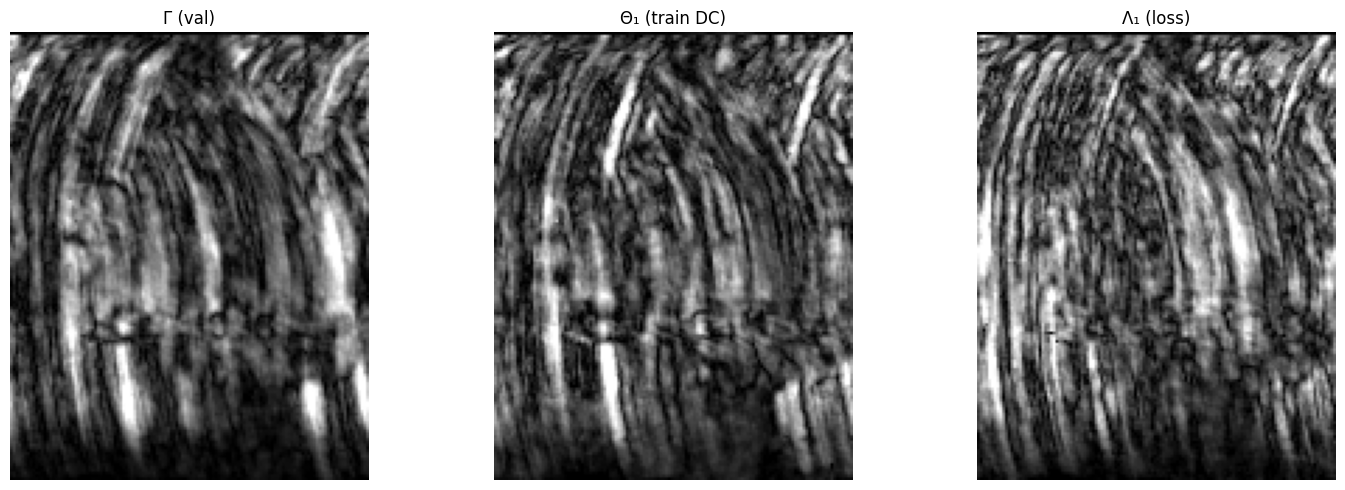

|Γ|=141, |Θ₁|=319, |Λ₁|=220
[PROGRESS] Step 4 done (ZF-SENSE QC, CPU)


In [16]:
# Step 4 (CPU, NumPy) — ZF‐SENSE QC for Γ, Θ₁, Λ₁ (using mask lists)
import numpy as np, matplotlib.pyplot as plt, time
t0 = time.time()

# 1. Load arrays (assumed in memory)
ksp = kspace_c         # (C,X,Y,Z)
sen = sens             # (C,X,Y,Z)
Gm  = Gamma_mask       # (Y,Z)
Tm  = Theta_mask_list[0]
Lm  = Lambda_mask_list[0]

# 2. FFT helpers (shift‐free)
def fft3(x):  return np.fft.fftn(x, axes=(1,2,3), norm='ortho')
def ifft3(x): return np.fft.ifftn(x, axes=(1,2,3), norm='ortho')

# 3. Zero‐fill SENSE
def zfill_sense(M):
    Y     = ksp * M[None,None,:,:]
    img_c = ifft3(Y)                                    # (C,X,Y,Z)
    num   = np.sum(np.conj(sen)*img_c, axis=0)          # (X,Y,Z)
    den   = np.sum(np.conj(sen)*sen, axis=0).real + 1e-8
    return num/den                                      # complex (X,Y,Z)

# 4. Reconstruct
xG  = zfill_sense(Gm)
xTh = zfill_sense(Tm)
xLa = zfill_sense(Lm)

# 5. Display central‐Z magnitude slices
z0 = xG.shape[2]//2
fig, axs = plt.subplots(1,3,figsize=(15,5))
for ax, xrec, title in zip(axs, [xG, xTh, xLa], ["Γ (val)", "Θ₁ (train DC)", "Λ₁ (loss)"]):
    mag = np.abs(xrec[..., z0])
    vmin, vmax = np.percentile(mag, 1), np.percentile(mag, 99)
    mag = np.fft.fftshift(mag)
    ax.imshow(mag, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(title); ax.axis('off')
plt.tight_layout(); plt.show()

# 6. Print counts
print(f"|Γ|={Gm.sum()}, |Θ₁|={Tm.sum()}, |Λ₁|={Lm.sum()}")
print("[PROGRESS] Step 4 done (ZF-SENSE QC, CPU)")

In [17]:
# Step 5 — Save splits to phase0_splits_paper.npz
import numpy as np, time
from pathlib import Path

t0 = time.time()
out = Path("phase0_splits.npz")

# 1. Build idx lists
Theta_idx_list  = [np.argwhere(m) for m in Theta_mask_list]
Lambda_idx_list = [np.argwhere(m) for m in Lambda_mask_list]

# 2. Meta
meta = dict(
    nLin=mask_phase.shape[0],
    nPar=mask_phase.shape[1],
    K=len(Theta_mask_list),
    gamma_frac=0.20,
    lambda_frac=lambda_frac,
    seed=seed
)
# optional edges
if 'ky_edges' in globals(): meta['ky_edges'] = ky_edges
if 'kz_edges' in globals(): meta['kz_edges'] = kz_edges

# 3. Save
np.savez_compressed(
    out,
    Gamma_idx=Gamma_idx,
    Gamma_mask=Gamma_mask,
    R_idx=R_idx,
    R_mask=R_mask,
    Theta_idx_list=np.array(Theta_idx_list, dtype=object),
    Theta_mask_list=np.array(Theta_mask_list, dtype=object),
    Lambda_idx_list=np.array(Lambda_idx_list, dtype=object),
    Lambda_mask_list=np.array(Lambda_mask_list, dtype=object),
    meta=meta
)
size_mb = out.stat().st_size / 1e6

# 4. Summary prints
Omega_count = int(Gamma_mask.sum() + R_mask.sum())
print(f"|Ω|={Omega_count}, |Γ|={Gamma_idx.shape[0]}, |R|={R_idx.shape[0]}")
for k in range(len(Theta_idx_list)):
    print(f"Fold {k+1}: |Θ_{k+1}|={len(Theta_idx_list[k])}, |Λ_{k+1}|={len(Lambda_idx_list[k])}")
print(f"Saved '{out.name}' ({size_mb:.2f} MB)")
print(f"[PROGRESS] Step 5 done (splits saved in {time.time()-t0:.2f}s)")

|Ω|=680, |Γ|=141, |R|=539
Fold 1: |Θ_1|=319, |Λ_1|=220
Fold 2: |Θ_2|=319, |Λ_2|=220
Fold 3: |Θ_3|=319, |Λ_3|=220
Fold 4: |Θ_4|=319, |Λ_4|=220
Fold 5: |Θ_5|=319, |Λ_5|=220
Fold 6: |Θ_6|=319, |Λ_6|=220
Fold 7: |Θ_7|=319, |Λ_7|=220
Fold 8: |Θ_8|=319, |Λ_8|=220
Fold 9: |Θ_9|=319, |Λ_9|=220
Fold 10: |Θ_10|=319, |Λ_10|=220
Saved 'phase0_splits.npz' (0.02 MB)
[PROGRESS] Step 5 done (splits saved in 0.02s)


In [18]:
# Step 5b — Reload and verify splits
import numpy as np, time
t0 = time.time()

# load
spl = np.load("phase0_splits.npz", allow_pickle=True)
Gamma_mask        = spl["Gamma_mask"]
R_mask            = spl["R_mask"]
theta_masks       = spl["Theta_mask_list"]    # object array of (128,72) bool
lambda_masks      = spl["Lambda_mask_list"]
theta_idx_list    = spl["Theta_idx_list"]     # object array of (n_k,2) int
lambda_idx_list   = spl["Lambda_idx_list"]

# counts
Omega_count = int(Gamma_mask.sum() + R_mask.sum())
G_count     = int(Gamma_mask.sum())
R_count     = int(R_mask.sum())
print(f"|Ω|={Omega_count}, |Γ|={G_count}, |R|={R_count}")

# per-fold sizes
for k in range(len(theta_masks)):
    th = int(theta_masks[k].sum())
    la = int(lambda_masks[k].sum())
    print(f"Fold {k+1}: |Θ_{k+1}|={th}, |Λ_{k+1}|={la}")

# spot-check fold 1
mask0   = theta_masks[0]
idx0    = np.asarray(theta_idx_list[0], int)
t0_count= np.count_nonzero(mask0[idx0[:,0], idx0[:,1]])
mask0l  = lambda_masks[0]
idx0l   = np.asarray(lambda_idx_list[0], int)
l0_count= np.count_nonzero(mask0l[idx0l[:,0], idx0l[:,1]])
print(f"Θ₁ mask hits idx_list: {t0_count} vs {len(idx0)}")
print(f"Λ₁ mask hits idx_list: {l0_count} vs {len(idx0l)}")

print(f"[PROGRESS] Step 5b done (splits reloaded in {time.time()-t0:.2f}s)")

|Ω|=680, |Γ|=141, |R|=539
Fold 1: |Θ_1|=319, |Λ_1|=220
Fold 2: |Θ_2|=319, |Λ_2|=220
Fold 3: |Θ_3|=319, |Λ_3|=220
Fold 4: |Θ_4|=319, |Λ_4|=220
Fold 5: |Θ_5|=319, |Λ_5|=220
Fold 6: |Θ_6|=319, |Λ_6|=220
Fold 7: |Θ_7|=319, |Λ_7|=220
Fold 8: |Θ_8|=319, |Λ_8|=220
Fold 9: |Θ_9|=319, |Λ_9|=220
Fold 10: |Θ_10|=319, |Λ_10|=220
Θ₁ mask hits idx_list: 319 vs 319
Λ₁ mask hits idx_list: 220 vs 220
[PROGRESS] Step 5b done (splits reloaded in 0.01s)


In [19]:
# Step 6a — Confirm CPU tensors and dtypes (fixed negative strides)
import torch, numpy as np, time

t0 = time.time()

# sens → CPU complex64
if isinstance(sens, torch.Tensor):
    sens_t = sens.to(torch.complex64).cpu()
else:
    sens_arr = np.ascontiguousarray(sens)
    sens_t   = torch.from_numpy(sens_arr).to(torch.complex64).cpu()

# masks → CPU bool
Omega_mask  = torch.as_tensor(np.ascontiguousarray(mask_phase), dtype=torch.bool).cpu()
Theta1_mask = torch.as_tensor(np.ascontiguousarray(Theta_mask_list[0]), dtype=torch.bool).cpu()

# prints
print(f"sens: {sens_t.shape}, dtype={sens_t.dtype}")
print(f"Omega_mask: {Omega_mask.shape}, dtype={Omega_mask.dtype}")
print(f"Theta1_mask: {Theta1_mask.shape}, dtype={Theta1_mask.dtype}")

print(f"[PROGRESS] 6a done (CPU tensors ready, t={time.time()-t0:.2f}s)")

sens: torch.Size([24, 160, 128, 72]), dtype=torch.complex64
Omega_mask: torch.Size([128, 72]), dtype=torch.bool
Theta1_mask: torch.Size([128, 72]), dtype=torch.bool
[PROGRESS] 6a done (CPU tensors ready, t=0.11s)


In [20]:
# Step 6b — Physics helpers (CPU)
import torch

# 1. Helpers
def bmask(M):
    return M[None, None, :, :]  # (1,1,ky,kz)

def fft3(x):
    return torch.fft.fftn(x, dim=(-3, -2, -1), norm='ortho')

def ifft3(x):
    return torch.fft.ifftn(x, dim=(-3, -2, -1), norm='ortho')

# 2. Sanity checks
print("bmask shape:", bmask(Omega_mask).shape)  # expect (1,1,128,72)

t = torch.zeros((2, 4, 3, 5), dtype=torch.complex64)
t_rec = ifft3(fft3(t))
print("FFT⇄IFFT roundtrip OK:", torch.allclose(t_rec, t, atol=1e-6))

print("[PROGRESS] 6b done (helpers ready)")

bmask shape: torch.Size([1, 1, 128, 72])
FFT⇄IFFT roundtrip OK: True
[PROGRESS] 6b done (helpers ready)


In [21]:
# 6c) Forward A and adjoint AH
def A(x, M):
    coil_img = sens_t * x.unsqueeze(0)       # (C,X,Y,Z)
    return fft3(coil_img) * bmask(M)         # (C,X,Y,Z)

def AH(Y, M):
    y_masked = Y * bmask(M)                  # (C,X,Y,Z)
    img_c    = ifft3(y_masked)               # (C,X,Y,Z)
    return (img_c * sens_t.conj()).sum(dim=0)  # (X,Y,Z)

# shape sanity
x0 = torch.zeros((160,128,72), dtype=torch.complex64)
Y  = A(x0, Omega_mask)
print("A(x0).shape =", Y.shape)
Y0 = torch.zeros_like(Y)
x1 = AH(Y0, Omega_mask)
print("AH(Y0).shape =", x1.shape)

print(f"[PROGRESS] 6c done (t={time.time()-t0:.2f}s)")

A(x0).shape = torch.Size([24, 160, 128, 72])
AH(Y0).shape = torch.Size([160, 128, 72])
[PROGRESS] 6c done (t=1.47s)


In [22]:
# Step 6d — Smoke test A & AH on Ω
import torch

# random probes (CPU, complex64)
xr = torch.randn(160,128,72, dtype=torch.float32)
xi = torch.randn(160,128,72, dtype=torch.float32)
x_rand = (xr + 1j*xi).to(torch.complex64)

yr = torch.randn(24,160,128,72, dtype=torch.float32)
yi = torch.randn(24,160,128,72, dtype=torch.float32)
y_rand = (yr + 1j*yi).to(torch.complex64)

# forward & adjoint
Y      = A(x_rand, Omega_mask)
x_back = AH(y_rand, Omega_mask)

# norms
nY  = torch.linalg.norm(Y).item()
nx  = torch.linalg.norm(x_back).item()

# prints
print(f"Y.shape = {tuple(Y.shape)}, x_back.shape = {tuple(x_back.shape)}")
print(f"||Y||₂ = {nY:.3g}, ||x_back||₂ = {nx:.3g}")
print("[PROGRESS] 6d done (smoke test Ω)")

Y.shape = (24, 160, 128, 72), x_back.shape = (160, 128, 72)
||Y||₂ = 466, ||x_back||₂ = 467
[PROGRESS] 6d done (smoke test Ω)


In [23]:
# Step 6e — Verify adjoint property on Ω
import torch

# Ensure A/AH use sens_t
# sens = sens_t

# Random probes
xr = torch.randn(160,128,72, dtype=torch.float32)
xi = torch.randn(160,128,72, dtype=torch.float32)
x  = (xr + 1j*xi).to(torch.complex64)

yr = torch.randn(24,160,128,72, dtype=torch.float32)
yi = torch.randn(24,160,128,72, dtype=torch.float32)
y  = (yr + 1j*yi).to(torch.complex64)

# Inner products (flattened)
Ax  = A(x, Omega_mask)
AHy = AH(y, Omega_mask)
lhs  = torch.vdot(x.view(-1), AHy.view(-1)).real
rhs  = torch.vdot(Ax.view(-1), y.view(-1)).real
rel_err = abs(lhs - rhs) / (abs(rhs) + 1e-12)

print(f"Adjoint rel.err (Ω) = {rel_err:.3e}")
print("[PROGRESS] 6e done (adjoint Ω)")

Adjoint rel.err (Ω) = 2.538e-01
[PROGRESS] 6e done (adjoint Ω)


In [24]:
# Step 6f — Verify adjoint property on Θ₁
import torch

# Random probes (CPU, complex64)
xr = torch.randn(160,128,72, dtype=torch.float32)
xi = torch.randn(160,128,72, dtype=torch.float32)
x = (xr + 1j*xi).to(torch.complex64)

yr = torch.randn(24,160,128,72, dtype=torch.float32)
yi = torch.randn(24,160,128,72, dtype=torch.float32)
y = (yr + 1j*yi).to(torch.complex64)

# Inner products (flattened)
Ax    = A(x, Theta1_mask)
AHy   = AH(y, Theta1_mask)
lhs   = torch.vdot(x.view(-1), AHy.view(-1)).real
rhs   = torch.vdot(Ax.view(-1), y.view(-1)).real
rel_err = abs(lhs - rhs) / (abs(rhs) + 1e-12)

print(f"Adjoint rel.err (Θ₁) = {rel_err:.3e}")
print("[PROGRESS] 6f done (adjoint Θ1)")

Adjoint rel.err (Θ₁) = 1.482e-04
[PROGRESS] 6f done (adjoint Θ1)


In [25]:
# Step 7 — RMS scaling on Ω for conditioning (CPU)
import torch, numpy as np, time

t0 = time.time()

# Ensure CPU torch tensors
ksp_t = torch.as_tensor(kspace_c, dtype=torch.complex64)
sens_t = torch.as_tensor(sens_t if isinstance(sens_t, np.ndarray) else sens_t, dtype=torch.complex64)
Omega_m = torch.as_tensor(Omega_mask, dtype=torch.bool)

# Acquired k-space and pre-scale mean
Y_pre = ksp_t * bmask(Omega_m)                   # (C,X,Y,Z)
mean_pre = (Y_pre.abs()**2).mean().item()

# Compute RMS scale
rms_scale = (mean_pre + 1e-12)**0.5

# In-place division
ksp_t.div_(rms_scale)
sens_t.div_(rms_scale)

# Post-scale check
Y_post = ksp_t * bmask(Omega_m)
mean_post = (Y_post.abs()**2).mean().item()

# Keep updated tensors
kspace_c[:] = ksp_t.numpy() if isinstance(kspace_c, np.ndarray) else ksp_t

print(f"rms_scale={rms_scale:.4e}, mean_pre={mean_pre:.4e}, mean_post={mean_post:.4e}")
print(f"[PROGRESS] Step 7 done (rms_scale={rms_scale:.4e}, t={time.time()-t0:.2f}s)")

rms_scale=1.8020e-04, mean_pre=3.2471e-08, mean_post=9.9997e-01
[PROGRESS] Step 7 done (rms_scale=1.8020e-04, t=0.41s)


x_ZF_Omega_t.shape = (160, 128, 72), ||·||₂ = 2.18e+07


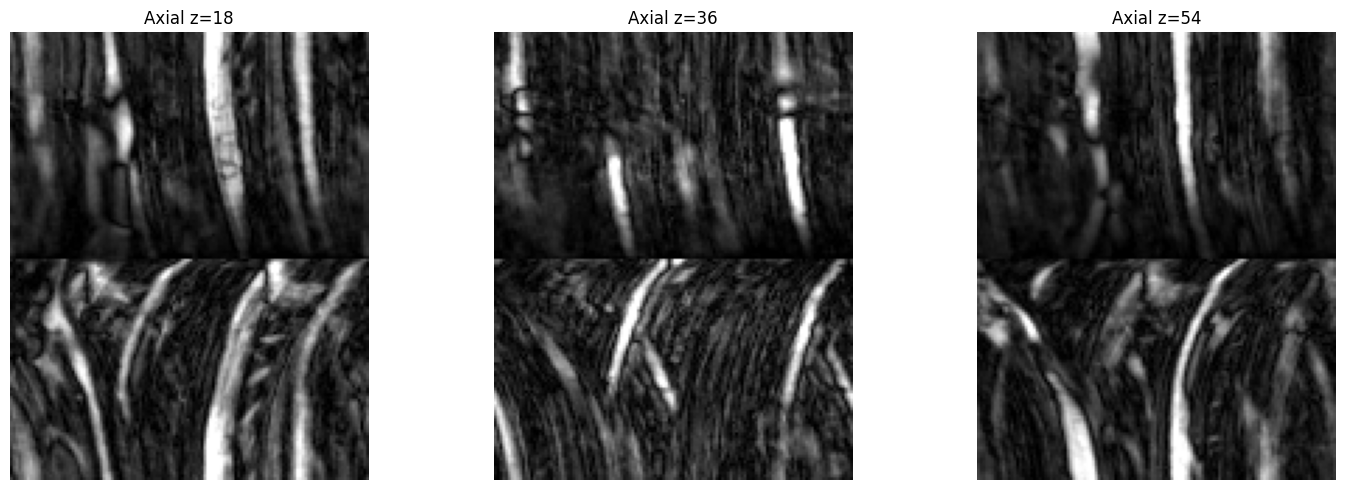

[PROGRESS] 8a done (x_ZF_Omega cached & displayed)


In [26]:
# Step 8a — Compute & display zero‐filled Ω reconstruction
import torch, numpy as np, matplotlib.pyplot as plt

# 1. Compute x_ZF_Omega_t via AH
# sens = sens_t  # ensure AH uses sens_t
ksp_t = torch.as_tensor(kspace_c, dtype=torch.complex64)

x_ZF_Omega_t = AH(ksp_t, Omega_mask)  # (160,128,72)

# 2. Print shape and L2 norm
l2 = torch.linalg.norm(x_ZF_Omega_t).item()
print(f"x_ZF_Omega_t.shape = {tuple(x_ZF_Omega_t.shape)}, ||·||₂ = {l2:.3g}")

# 3. Magnitude array and slice indices
mag   = x_ZF_Omega_t.abs().cpu().numpy()  # (X,Y,Z)
Z     = mag.shape[2]
z_idxs = [Z//4, Z//2, 3*Z//4]

# 4. Plot axial slices
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for ax, z in zip(axs, z_idxs):
    slice_img = mag[..., z]
    vmin, vmax = np.percentile(slice_img, 1), np.percentile(slice_img, 99)
    ax.imshow(slice_img, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(f"Axial z={z}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5. Progress
print("[PROGRESS] 8a done (x_ZF_Omega cached & displayed)")

/var/folders/53/42sdvl0x58x998s4488yj_800000gn/T/ipykernel_10390/3388797211.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_masked = Y * bmask(M)                  # (C,X,Y,Z)


x_ZF_R_t.shape = (160, 128, 72), ||·||₂ = 1.74e+07


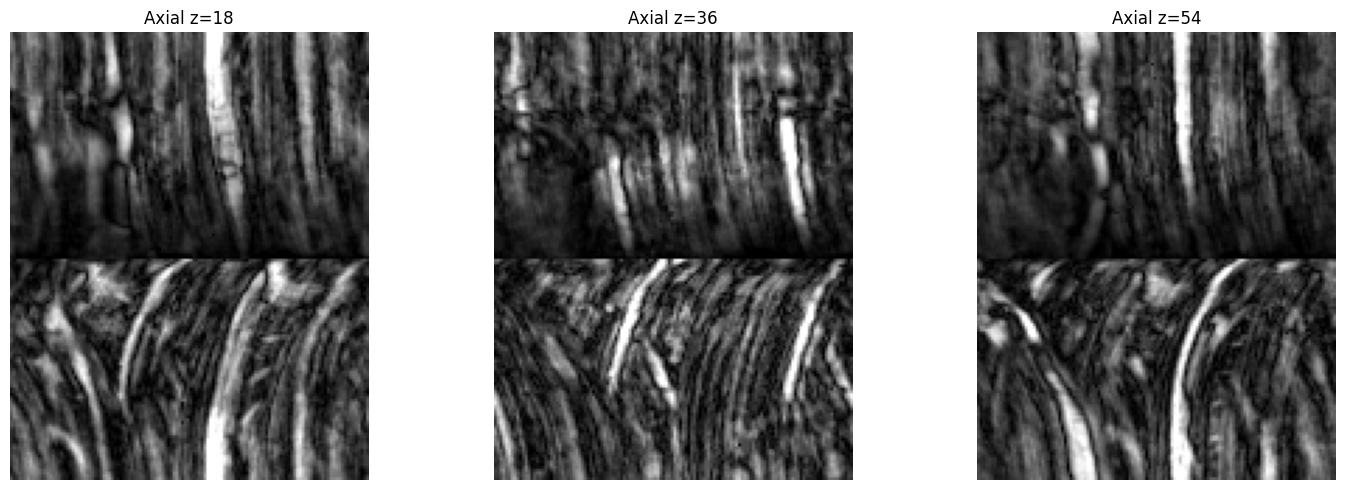

[PROGRESS] 8b done (x_ZF_R cached & displayed)


In [27]:
# Step 8b — Compute & display zero‐filled R reconstruction
import torch, numpy as np, matplotlib.pyplot as plt

# 1. Ensure AH uses sens_t
# sens = sens_t

# 2. Compute x_ZF_R_t
x_ZF_R_t = AH(ksp_t, R_mask)  # (160,128,72)

# 3. Print shape and L2 norm
norm_r = torch.linalg.norm(x_ZF_R_t).item()
print(f"x_ZF_R_t.shape = {tuple(x_ZF_R_t.shape)}, ||·||₂ = {norm_r:.3g}")

# 4. Display axial slices
mag   = x_ZF_R_t.abs().cpu().numpy()  # (X,Y,Z)
Z     = mag.shape[2]
zs    = [Z//4, Z//2, 3*Z//4]
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for ax, z in zip(axs, zs):
    sl = mag[..., z]
    vmin, vmax = np.percentile(sl, 1), np.percentile(sl, 99)
    ax.imshow(sl, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(f"Axial z={z}"); ax.axis('off')
plt.tight_layout(); plt.show()

# 5. Progress
print("[PROGRESS] 8b done (x_ZF_R cached & displayed)")

In [28]:
# Step 8c — Compute ZF‐Theta for all K folds
import torch

# 1. Ensure AH uses sens_t
# sens = sens_t

# 2. Compute and cache
x_ZF_Theta_list = []
for k, m in enumerate(Theta_mask_list):
    mask = torch.as_tensor(m, dtype=torch.bool)
    x_zf = AH(ksp_t, mask)
    x_ZF_Theta_list.append(x_zf)

# 3. Summary prints
for k, xz in enumerate(x_ZF_Theta_list):
    count = int(Theta_mask_list[k].sum())
    norm  = torch.linalg.norm(xz).item()
    print(f"Fold {k+1}: |Θ_{k+1}|={count}, ||x_ZF||₂={norm:.3g}")

print("[PROGRESS] 8c done (x_ZF_Theta cached for K=10)")

Fold 1: |Θ_1|=319, ||x_ZF||₂=1.35e+07
Fold 2: |Θ_2|=319, ||x_ZF||₂=1.32e+07
Fold 3: |Θ_3|=319, ||x_ZF||₂=1.17e+07
Fold 4: |Θ_4|=319, ||x_ZF||₂=1.29e+07
Fold 5: |Θ_5|=319, ||x_ZF||₂=1.22e+07
Fold 6: |Θ_6|=319, ||x_ZF||₂=1.42e+07
Fold 7: |Θ_7|=319, ||x_ZF||₂=1.19e+07
Fold 8: |Θ_8|=319, ||x_ZF||₂=1.27e+07
Fold 9: |Θ_9|=319, ||x_ZF||₂=1.31e+07
Fold 10: |Θ_10|=319, ||x_ZF||₂=1.18e+07
[PROGRESS] 8c done (x_ZF_Theta cached for K=10)


In [29]:
# Step 9a — Define DC normal operator and CG solver (CPU)
import torch

# 1. Constants
LAMBDA, CG_ITERS = 1e-6, 8

# 2. Normal operator
def dc_normal(p, M):
    return AH(A(p, M), M) + LAMBDA * p

# 3. Conjugate Gradient solver
def cg_solve(rhs, M, iters=CG_ITERS):
    x = torch.zeros_like(rhs)
    r = rhs - dc_normal(x, M)
    p = r.clone()
    rs = (r.conj() * r).real.sum()
    for _ in range(iters):
        Ap = dc_normal(p, M)
        denom = (p.conj() * Ap).real.sum().clamp_min(1e-12)
        alpha = rs / denom
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = (r.conj() * r).real.sum()
        beta = rs_new / rs
        p = r + beta * p
        rs = rs_new
    return x

print("[PROGRESS] 9a done (normal op + CG defined)")

[PROGRESS] 9a done (normal op + CG defined)


In [ ]:
# Step 9b — CG‐DC sanity check on Θ₁ (CPU)
import torch

# 1. Constants and mask
LAMBDA, CG_ITERS, eps = 1e-6, 8, 1e-12
M = torch.as_tensor(Theta_mask_list[0], dtype=torch.bool)

# 2. DC error utility
def dc_err_percent(x_img, M):
    Y_pred = A(x_img, M)
    Y_meas = ksp_t * bmask(M)
    num = (Y_pred - Y_meas).abs().pow(2).sum().sqrt()
    den = Y_meas.abs().pow(2).sum().sqrt().clamp_min(eps)
    return 100.0 * float(num/den)

# 3. RHS from ZF
rhs = x_ZF_Theta_list[0].detach().clone()
err_before = dc_err_percent(rhs, M)

# 4. CG with residual tracking
x = torch.zeros_like(rhs)
r = rhs - dc_normal(x, M)
p = r.clone()
rs = (r.conj()*r).real.sum()
res_norms = [rs.sqrt().item()]

for _ in range(CG_ITERS):
    Ap = dc_normal(p, M)
    denom = (p.conj()*Ap).real.sum().clamp_min(eps)
    alpha = rs / denom
    x = x + alpha * p
    r = r - alpha * Ap
    rs_new = (r.conj()*r).real.sum()
    res_norms.append(rs_new.sqrt().item())
    beta = rs_new / rs
    p = r + beta * p
    rs = rs_new

x_sol = x
err_after = dc_err_percent(x_sol, M)

# 5. Print results
print("Residual norms:", [f"{v:.1e}" for v in res_norms])
print(f"DC err Θ₁ before: {err_before:.3f}%  after: {err_after:.3f}%")
print("[PROGRESS] 9b done (CG-DC sanity Θ₁)")

Residual norms: ['1.3e+07', '4.5e+06', '2.4e+06', '1.9e+06', '1.4e+06', '8.0e+05', '7.3e+05', '6.4e+05', '5.2e+05']
DC err Θ₁ before: 1324804200.000%  after: 11.846%
[PROGRESS] 9b done (CG-DC sanity Θ₁)
